# Proyecto 4: Informe final de carrera

### Planteamiento del problema

**Dataset**
Características y precios de inmuebles en Buenos Aires ([link](https://drive.google.com/a/acamica.com/uc?export=download&id=1Ugbsw5XbNRbglomSQO1qkAgMFB_3BzmB))

**Objetivo**
Estudiar la viabilidad de mejorar y expandir el área de cobertura de las predicciones mediante la inclusión de métodos adicionales al análisis.

**Métodos a implementar**

* Imputación de datos.
* Inclusión de otros tipos de propiedades.
* Uso del modelo `XGBoost`.

**Preguntas a responder**
* ¿Es posible mejorar el desempeño del modelo imputando valores faltantes?
* ¿Es posible incluir otros tipos de propiedades sin afectar su desempeño?
* ¿Aplicar un modelo basado en `Boosting` como `XGBosst` tendrá un mejor desempeño en este problema?

**Resultados esperados**

* Imputando datos, se espera una mejora en el desempeño del modelo.
* Incluir otros tipo de propiedades, expandirá la cobertura de predicciones del modelo sin afectar su desempeño.

**Punto de partida**

Este análisis se basará en los resultados encontrados en los dos primeros proyectos que abarcaron el mismo problema:

* __Mejor modelo:__ Random Forest.
* __Métrica:__ RMSE.
* __Features usadas:__

    * Latitud (lat).
    * Longitud (lon).
    * Ambientes (rooms).
    * Habitaciones (bedrooms).
    * Baños (bathrooms > 0).
    * Superficie Total (surface_total <= 1000).
    * Supercifie Cubierta (surface_covered >= 18).
    * Tipo de Propiedad (property_type).
    * Precio (price >= 39000).
    * Barrio (l3).
    * Región (l2 = Capital Federal).

* __Técnicas usadas:__

    * Validar consistencia de datos (e.g. surface_total >= surface_covered).
    * Eliminación de valores atípicos: criterio de los 3 sigmas.
    * PCA manteniendo el 95% de varianza en los datos.


### Preparación de datos

Para comenzar el análisis correspondiente a este notebook, se aplicarán las técnicas necesarias para limpiar el dataset y tener registros válidos.

Se importan las librerías y definen las funciones necesarias:

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from time import time

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

In [106]:
random_state = 2021-3-6
test_size = 0.1
n_iter = 3
n_processors = 2

In [94]:
def count_removed_rows(initial, final):
    print(f"{initial - final} rows were removed")

def detect_outliers_3_sigma(data, criteria='3sigma'):
    data_description = data.describe()
    data_mean = data_description.loc['mean']
    data_std = data_description.loc['std']
    criteria_max = data_mean + 3 * data_std
    criteria_min = data_mean - 3 * data_std
    return (data < criteria_min) | (data > criteria_max)

def study_model(model, data, scoring="neg_root_mean_squared_error"):
    start = time()

    X_train, y_train = data
    model.fit(X_train, y_train)

    end = time()
    time_elapsed = end - start
    is_time_min = time_elapsed > 60
    if is_time_min:
        time_elapsed = time_elapsed / 60
    print(f"Time elapsed: {time_elapsed:0.4f} {'min' if is_time_min else 'sg'}")

def hyperparameter_optimization(model, params, data, strategy='random', n_iter=10, random_state=random_state, cv=5, scoring='neg_root_mean_squared_error'):
    search = RandomizedSearchCV(model, param_distributions=params, cv=cv, scoring=scoring, n_jobs=n_processors, n_iter=n_iter, random_state=random_state)
    study_model(search, data, scoring=scoring)
    print(f"Iterations: {n_iter}")
    print(f"Search strategy: {strategy}")
    print(f"Best params: {search.best_params_}")
    print(f"Best score ({cv}-fold CV): {-search.best_score_:0.2f} USD")
    return search

def plot_residuals(y, residuals, labels, legend=True):
    plt.figure(figsize=(15,5))
    sns.scatterplot(x=y/1000, y=residuals/1000, hue=labels, legend=legend)
    plt.xlabel('Price (kUSD)')
    plt.ylabel('Residual (kUSD)')
    plt.title('Residuals vs Prices')
    plt.show()

Se importan los datos:

In [56]:
dataset = pd.read_csv('properati.csv')
dataset.head()

,start_date,end_date,created_on,lat,lon,l1,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,currency,title,description,property_type,operation_type
0,2019-10-17,2019-12-23,2019-10-17,-34.605880,-58.384949,Argentina,Capital Federal,San Cristobal,7.0,7.0,2.0,140.0,140.0,153000.0,USD,"***Venta semipiso centro, ideal hostel*****",DESCRIPCION DE LA PROPIEDAD: Departamento de 1...,Departamento,Venta
1,2019-10-17,2019-11-21,2019-10-17,-34.624056,-58.412110,Argentina,Capital Federal,Boedo,2.0,1.0,2.0,70.0,58.0,159000.0,USD,Espectacular PH reciclado en Boedo sin expensas.,PH reciclado en Boedo a una cuadra de la plaz...,PH,Venta
2,2019-10-17,2019-11-01,2019-10-17,-34.593569,-58.427474,Argentina,Capital Federal,Palermo,2.0,1.0,1.0,45.0,45.0,125000.0,USD,Depto.tipo casa de 2 ambientes en Venta en Pal...,"2 ambienets amplio , excelente estado , patio ...",PH,Venta
3,2019-10-17,2019-12-23,2019-10-17,-34.581294,-58.436754,Argentina,Capital Federal,Palermo,2.0,1.0,1.0,85.0,50.0,295000.0,USD,COSTA RICA 5800 / PALERMO HOLLYWOOD / VENTA PH...,HERMOSO PH EN PALERMO!!!2 AMBIENTES TOTALMENTE...,PH,Venta
4,2019-10-17,2020-03-11,2019-10-17,-34.914194,-57.938219,Argentina,Bs.As. G.B.A. Zona Sur,La Plata,2.0,1.0,1.0,50.0,35.0,40000.0,USD,58 entre 1 y 2 Venta de departamento en ph.1 ...,58 entre 1 y 2 Venta de departamento en PH. P...,PH,Venta


Se conservan únicamente las features mencionadas y se aplican los filtros correspondientes:

In [57]:
initial_shape = dataset.shape[0]

dataset = dataset[['lat', 'lon', 'l2', 'l3', 'rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered', 'property_type', 'price']]
dataset = dataset[dataset.l2 == "Capital Federal"]
dataset.drop(axis=1, columns=["l2"], inplace=True)

count_removed_rows(initial=initial_shape, final=dataset.shape[0])

54121 rows were removed


Se eliminan los registro inválidos:

In [58]:
initial_shape = dataset.shape[0]

valid_registry_criteria = 'rooms >= bedrooms & surface_total >= surface_covered & surface_covered >= 18 & surface_total <= 1000 & bathrooms > 0 & price >= 39000'
dataset.query(valid_registry_criteria, inplace=True)

count_removed_rows(initial=initial_shape, final=dataset.shape[0])

12056 rows were removed


Se removerán los valores atípicos usando el criterio de los 3 sigmas:

In [59]:
initial_shape = dataset.shape[0]

# Removing outliers
numeric_columns = ['lat', 'lon', 'rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered', 'price']
for column in numeric_columns:
    columns_to_keep = ~detect_outliers_3_sigma(dataset[column])
    dataset = dataset[columns_to_keep].copy()
    
count_removed_rows(initial=initial_shape, final=dataset.shape[0])
print(f"Final shape => {dataset.shape}")

8856 rows were removed
Final shape => (71627, 10)


Para poder medir si las técnicas que se desean usar son efectivas y capaces de responder las preguntas planteadas, se debe establecer un procedimiento a seguir. Para cada uno de ellos, se seguirán los siguientes pasos:

1. Se aplicará un `LabelEncoder` y `OneHotEncoder` sobre el tipo de propiedad.
1. Se hará un train/test split donde el test size será de 10%.
1. Se escalarán los datos.
1. Se generarán nuevas variables mediante el uso de PCA manteniendo al menos el 95% de la varianza de los datos.
1. Se entrenará un modelo de `RandomForest`, optimizando sus hiperparámetros usando `RandomizedSearchCV` con CV=5 y 20 iteraciones.
1. Se evaluará el RMSE del modelo en el conjunto de test.
1. Se mostrará un gráfico de los residuos por tipo de propiedad para poder encontrar posibles patrones en las predicciones.

La métrica usada en el último paso mencionado, es la que servirá para comparar la efectivadad de los métodos adicionales a aplicar en el presente análisis.

La siguiente función traduce los pasos anteriormente explicados en código:

In [108]:
def perform_analysis(tidy_dataset, test_size, random_state, n_iter, model, hyperparams, n_processors):
    # LabelEncoder & OneHotEncoder.
    property_type_label_encoder = LabelEncoder()
    tidy_dataset['property_type_encoded'] = property_type_label_encoder.fit_transform(tidy_dataset.property_type)

    property_type_one_hot_encoder = OneHotEncoder(sparse=False)
    property_type_encoded = property_type_one_hot_encoder.fit_transform(tidy_dataset.property_type_encoded.to_numpy().reshape(-1, 1))
    tidy_dataset = pd.concat([tidy_dataset.reset_index(drop=True), pd.DataFrame(property_type_encoded, columns=property_type_label_encoder.classes_)], axis=1)
    tidy_dataset.drop(['property_type_encoded'], axis=1, inplace=True)
    tidy_dataset.head()

    # Train/Test split
    label_columns = ['l3', 'property_type']
    X = tidy_dataset.drop(['price'], axis=1)
    y = tidy_dataset.price

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    X_train_labels = X_train[label_columns].copy()
    X_test_labels = X_test[label_columns].copy()

    X_train = X_train.drop(label_columns, axis=1).copy()
    X_test = X_test.drop(label_columns, axis=1).copy()

    # Scaling.
    columns_to_scale = ['lat', 'lon', 'rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered']
    ct = ColumnTransformer([('scaler', StandardScaler(), columns_to_scale)], remainder='passthrough')

    X_train = pd.DataFrame(ct.fit_transform(X_train), columns=X_train.columns)
    X_test = pd.DataFrame(ct.transform(X_test), columns=X_test.columns)

    # PCA (95% variance).
    pca_total = PCA(n_components=X_train.shape[1], random_state=random_state)
    pca_total.fit(X_train)
    
    cummulative_explained_variance = np.cumsum(pca_total.explained_variance_ratio_)
    n_components = (cummulative_explained_variance < 0.95).sum() + 1
    print(f'Number of principal components {n_components} ({100 * cummulative_explained_variance[n_components-1]:.2f}%)')

    pca = PCA(n_components=n_components, random_state=random_state)
    X_train = pca.fit_transform(X_train)
    X_test = pca.transform(X_test)
    
    # Model Training
    forest_search = hyperparameter_optimization(model=model, params=hyperparams, data=(X_train, y_train), n_iter=n_iter)

    # Model Evaluation
    y_test_pred = forest_search.predict(X_test)
    print(f'Test RMSE: {np.sqrt(mean_squared_error(y_test, y_test_pred)):.2f} USD')
    
    # Plot Residuals
    residuals = y_test - y_test_pred
    plot_residuals(y=y_test, residuals=residuals, labels=X_test_labels.property_type)

In [75]:
initial_shape = dataset.shape[0]

benchmark_dataset = dataset[dataset.property_type.isin(["Casa", "Departamento", "PH"])].copy()
benchmark_dataset.dropna(inplace=True)

count_removed_rows(initial=initial_shape, final=benchmark_dataset.shape[0])

3654 rows were removed


Comanzando con el análisis anteriormente mencionado:

Number of principal components 5 (95.52%)
Time elapsed: 52.7203 sg
Iterations: 3
Search strategy: random
Best params: {'max_depth': 31, 'max_features': 'sqrt', 'n_estimators': 167}
Best score (5-fold CV): 29949.05 USD
Test RMSE: 27516.02 USD


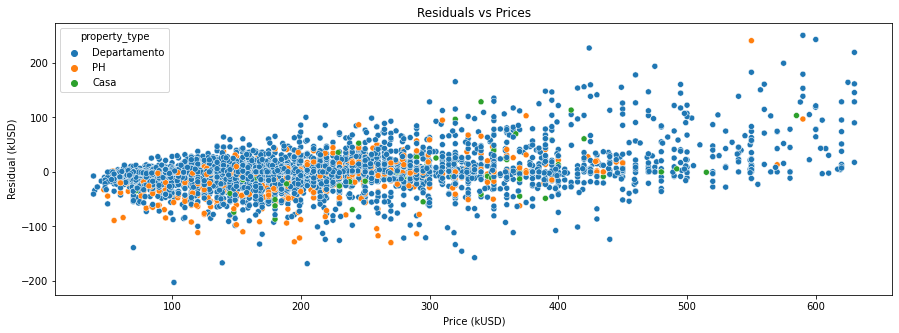

In [107]:
param_distributions = {
    'n_estimators': stats.randint(low=100,high=200),
    'max_depth': stats.randint(low=25,high=50),
    'max_features': ['auto', 'sqrt', 'log2']
}
forest = RandomForestRegressor(random_state=random_state, n_jobs=n_processors)
perform_analysis(model=forest, hyperparams=param_distributions, tidy_dataset=benchmark_dataset, test_size=test_size, random_state=random_state, n_iter=n_iter, n_processors=n_processors)

### ¿Es posible mejorar el desempeño del modelo imputando valores faltantes?

### ¿Es posible incluir otros tipos de propiedades sin afectar su desempeño?

### ¿Aplicar un modelo basado en `Boosting` como `XGBosst` tendrá un mejor desempeño en este problema?

### Análisis de resultados

### Conclusiones